In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import collections
import re
from matplotlib import colors as mcolors

import IPython

import sys
sys.path.append('../')
sys.path.append('/u/nlp/packages/anaconda2/lib/python2.7/site-packages/')
from experiments.suff_reg import *

In [23]:
global tot_train_losses, tot_test_losses, ave_train_losses, ave_test_losses, train_accs, test_accs

tot_train_losses = {'hospital': [], 'spam': [], 'mnist_small': []}
tot_test_losses = {'hospital': [], 'spam': [], 'mnist_small': []}
ave_train_losses = {'hospital': [], 'spam': [], 'mnist_small': []}
ave_test_losses = {'hospital': [], 'spam': [], 'mnist_small': []}
train_accs = {'hospital': [], 'spam': [], 'mnist_small': []}
test_accs = {'hospital': [], 'spam': [], 'mnist_small': []}

def plot_reg_summary():
    dataset_ids = ave_test_losses.keys()
    fig, axs = plt.subplots(len(dataset_ids), 2, figsize=(4*2, 4 * len(dataset_ids)), squeeze=False)
    for ax, dataset_id in zip(axs, dataset_ids):
        ax[0].plot(ave_train_losses[dataset_id], label='Average train loss w/o reg', color='r')
        ax[0].plot(ave_test_losses[dataset_id], label='Average test loss w/o reg', color='b')
        ax[0].legend()
        ax[0].set_title('{}'.format(dataset_id))
        
        ax[1].plot(train_accs[dataset_id], label='Train acc', color='r')
        ax[1].plot(test_accs[dataset_id], label='Test acc', color='b')
        ax[1].legend()
        ax[1].set_title('{}'.format(dataset_id))
    plt.savefig('../output/suff_reg_logreg/plots/reg_summary.png', bbox_inches="tight")
    plt.show()

def plot_all(exp_num):

    def load_data(exp_num):
        exp_ids = ['hospital_seed-0_size-0.1_num-10_reg-0.001',
                   'hospital_seed-0_size-0.1_num-10_reg-0.01',
                   'hospital_seed-0_size-0.1_num-10_reg-0.1',
                   'hospital_seed-0_size-0.1_num-10_reg-1.0',
                   'hospital_seed-0_size-0.1_num-10_reg-10.0',
                   'hospital_seed-0_size-0.1_num-10_reg-100.0',
                   'hospital_seed-0_size-0.1_num-10_reg-1000.0',
                   'hospital_seed-0_size-0.1_num-10_reg-10000.0',
                   'hospital_seed-0_size-0.1_num-10_reg-100000.0',
                   'spam_seed-0_size-0.1_num-7_reg-0.001',
                   'spam_seed-0_size-0.1_num-7_reg-0.01',
                   'spam_seed-0_size-0.1_num-7_reg-0.1',
                   'spam_seed-0_size-0.1_num-7_reg-1.0',
                   'spam_seed-0_size-0.1_num-7_reg-10.0',
                   'spam_seed-0_size-0.1_num-7_reg-100.0',
                   'mnist_small_seed-0_size-0.1_num-7_reg-0.01',
                   'mnist_small_seed-0_size-0.1_num-7_reg-0.1',
                   'mnist_small_seed-0_size-0.1_num-7_reg-1.0',
                  ]
        exp_id = exp_ids[exp_num]
        print('Experiment {}'.format(exp_id))
        exp = SufficientRegularizationLogreg.load_run(exp_id)
        print('Train loss {}, Test loss {}'.format(exp.R['train_loss'], exp.R['test_loss']))
        tot_train_losses[exp.config['dataset_config']['dataset_id']].append(exp.R['train_loss'])
        tot_test_losses[exp.config['dataset_config']['dataset_id']].append(exp.R['test_loss'])
        ave_train_losses[exp.config['dataset_config']['dataset_id']].append(exp.R['train_loss']/len(exp.train.x))
        ave_test_losses[exp.config['dataset_config']['dataset_id']].append(exp.R['test_loss']/len(exp.test.x))
        train_accs[exp.config['dataset_config']['dataset_id']].append(exp.R['train_acc'])
        test_accs[exp.config['dataset_config']['dataset_id']].append(exp.R['test_acc'])
        
        subset_tags = exp.R['subset_tags']
        for i, tag in enumerate(subset_tags):
            if re.search('pos_tail_test', tag):
                subset_tags[i] = 'pos_tail_test'
            elif re.search('neg_tail_test', tag):
                subset_tags[i] = 'neg_tail_test'
        unique_tags = np.unique(subset_tags)
        unique_tags = [tag.encode('ascii','replace') for tag in unique_tags]
        unique_subset_colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k', 'coral',\
                                'olive', 'dodgerblue', 'pink', 'khaki', 'peru',\
                                'indigo', 'orange', 'springgreen', 'rebeccapurple']
        assert len(unique_subset_colors) >= len(unique_tags)
        tag_to_color = dict(zip(unique_tags, range(len(unique_tags))))
        subset_colors = [unique_subset_colors[tag_to_color[tag]] for tag in subset_tags]
        
        return exp_id, exp, unique_tags, unique_subset_colors, subset_colors, subset_tags
        
    # Plot self-influence actual vs predicted
    def plot_self_infl_data(mode='loss'):
        assert mode in ['loss', 'margin']
        plt.figure(figsize=(4,4))
        W = 0
        if mode == 'loss':
            actl = exp.R['subset_self_actl_infl']
            pred = exp.R['subset_self_pred_infl']
        elif mode == 'margin':
            actl = exp.R['subset_self_actl_margin_infl']
            pred = exp.R['subset_self_pred_margin_infl']

        labels = set()
        W = max(np.max(np.abs(actl)), np.max(np.abs(pred)))
        plt.scatter(actl, pred, color=subset_colors, alpha=0.2)
        for i, tag in enumerate(unique_tags):
            plt.scatter(2*W, 2*W, color=unique_subset_colors[i], label=tag, alpha=0.2)

        if mode == 'loss':
            plt.plot([-W/20, W], [-W/20, W],color='grey',alpha=0.3)
            plt.xlim(-W/20,W)
            plt.ylim(-W/20,W)
        elif mode == 'margin':
            plt.plot([-W, W/20], [-W, W/20],color='grey',alpha=0.3)
            plt.xlim(-W,W/20)
            plt.ylim(-W,W/20)
        plt.title('Self-influence: {}, l2_reg {}, seed {}, {} subsets, proportion {}'.format(\
                exp.config['dataset_config']['dataset_id'],exp.config['normalized_cross_validation_range'][0],\
                exp.config['subset_seed'],exp.config['num_subsets'], exp.config['subset_rel_size']))
        plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), ncol=1)
        plt.xlabel('Actual sum of self-{} for subset'.format(mode))
        plt.ylabel('Predicted sum of self-{} for subset'.format(mode))
        plt.savefig('../output/suff_reg_logreg/plots/{}_self_{}.png'.format(exp_id, mode), bbox_inches="tight")
        plt.show()

    # Plot fixed test point actual vs predicted
    def plot_test_pt_data(mode='loss'):
        assert mode in ['loss', 'margin']
        test_points = exp.R['fixed_test']
        fig, axs = plt.subplots(len(test_points), 1, figsize=(4, 4 * len(test_points)), squeeze=False)
        
        for i, test_idx in enumerate(test_points):
            #if i > 0: break
            W = 0
            if mode == 'loss':
                actl = exp.R['subset_fixed_test_actl_infl'][:,i]
                pred = exp.R['subset_fixed_test_pred_infl'][:,i]
            elif mode == 'margin':
                actl = exp.R['subset_fixed_test_actl_margin_infl'][:,i]
                pred = exp.R['subset_fixed_test_pred_margin_infl'][:,i]

            labels = set()
            W = max(np.max(np.abs(actl)), np.max(np.abs(pred)))
            axs[i][0].scatter(actl, pred, color=subset_colors, alpha=0.2)
            for j, tag in enumerate(unique_tags):
                axs[i][0].scatter(2*W, 2*W, color=unique_subset_colors[j], label=tag, alpha=0.2)

            axs[i][0].plot([-W, W], [-W, W],color='grey',alpha=0.3)
            axs[i][0].set_title('Test_idx: {}; {}, l2_reg {}, seed {}, {} subsets, proportion {}'.format(test_idx,\
                        exp.config['dataset_config']['dataset_id'],\
                        exp.config['normalized_cross_validation_range'][0],\
                        exp.config['subset_seed'],exp.config['num_subsets'],exp.config['subset_rel_size']))
            axs[i][0].legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), ncol=1)
            axs[i][0].set_xlabel('Actual influence on test pt {}'.format(mode))
            axs[i][0].set_ylabel('Predicted influence on test pt {}'.format(mode))
            axs[i][0].set_xlim(-W*1.05, W*1.05)
            axs[i][0].set_ylim(-W*1.05, W*1.05)
        fig.subplots_adjust(hspace=0.4)
        plt.savefig('../output/suff_reg_logreg/plots/{}_test_{}.png'.format(exp_id, mode), bbox_inches="tight")
        plt.show()

    exp_id, exp, unique_tags, unique_subset_colors, subset_colors, subset_tags = load_data(exp_num)
    plot_self_infl_data()
    if exp.config['dataset_config']['dataset_id'] not in ['mnist_small', 'processed_imageNet']:
        plot_self_infl_data('margin')
    plot_test_pt_data()
    if exp.config['dataset_config']['dataset_id'] not in ['mnist_small', 'processed_imageNet']:
        plot_test_pt_data('margin')

Experiment hospital_seed-0_size-0.1_num-10_reg-0.001
Loading phase 0-report_reg from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-0.001/result_0-report_reg.npz
Loading phase 1-initial_training from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-0.001/result_1-initial_training.npz
Loading phase 2-pick_test_points from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-0.001/result_2-pick_test_points.npz
Loading phase 3-hessian from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-0.001/result_3-hessian.npz
Loading phase 4-fixed_test_influence from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-0.001/result_4-fixed_test_influence.npz

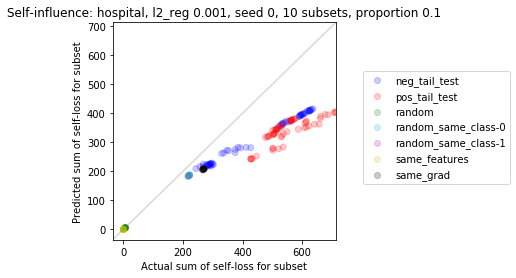

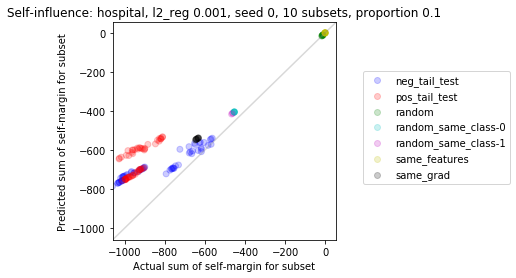

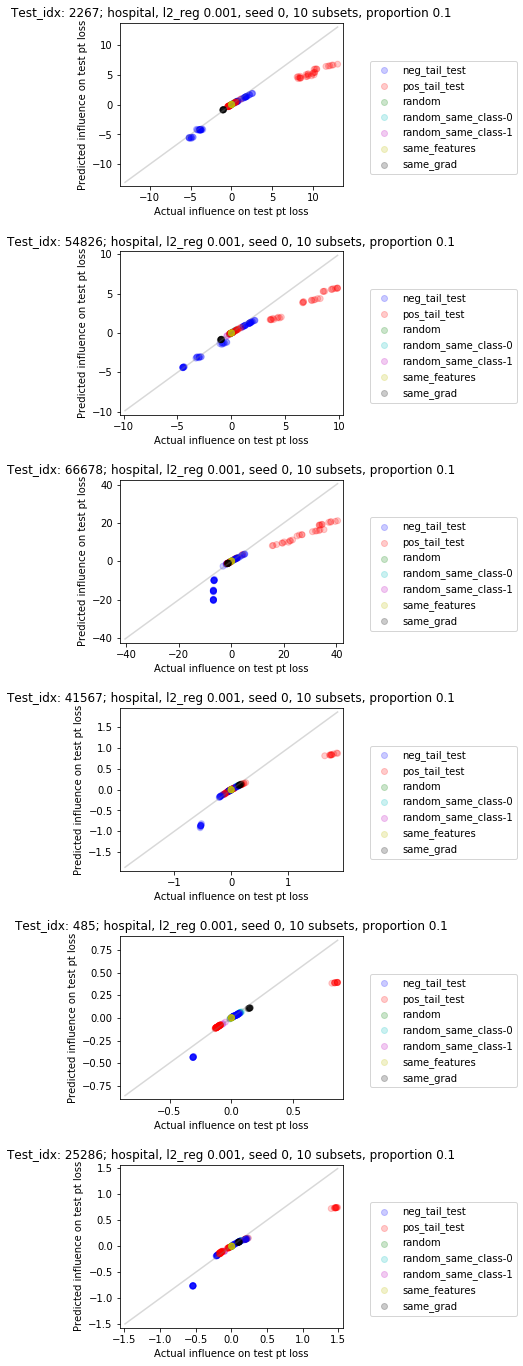

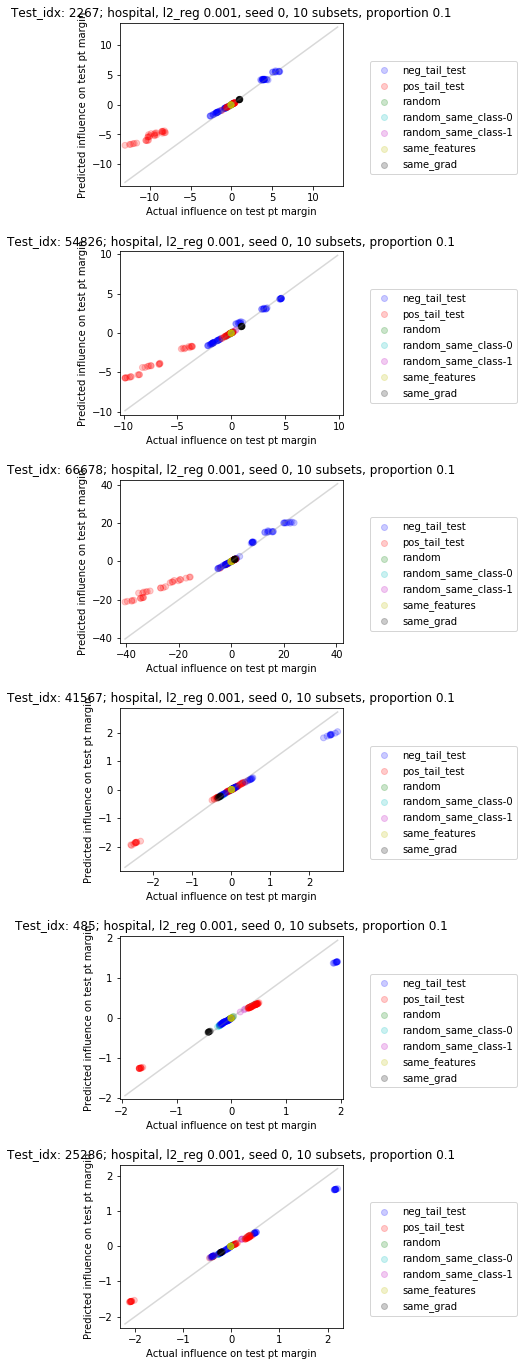

In [24]:
plot_all(0)

Experiment hospital_seed-0_size-0.1_num-10_reg-0.01
Loading phase 0-report_reg from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-0.01/result_0-report_reg.npz
Loading phase 1-initial_training from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-0.01/result_1-initial_training.npz
Loading phase 2-pick_test_points from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-0.01/result_2-pick_test_points.npz
Loading phase 3-hessian from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-0.01/result_3-hessian.npz
Loading phase 4-fixed_test_influence from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-0.01/result_4-fixed_test_influence.npz
Loadi

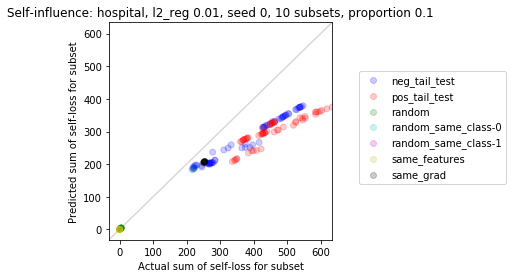

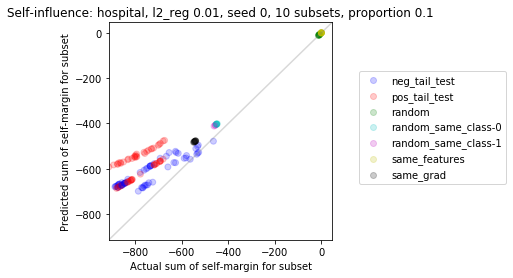

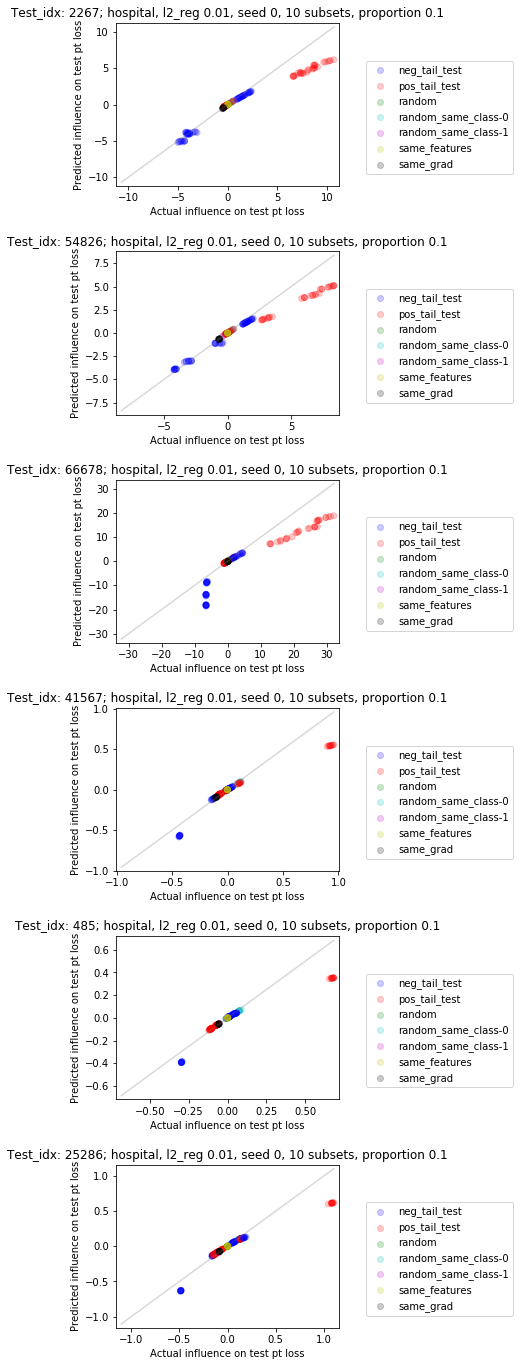

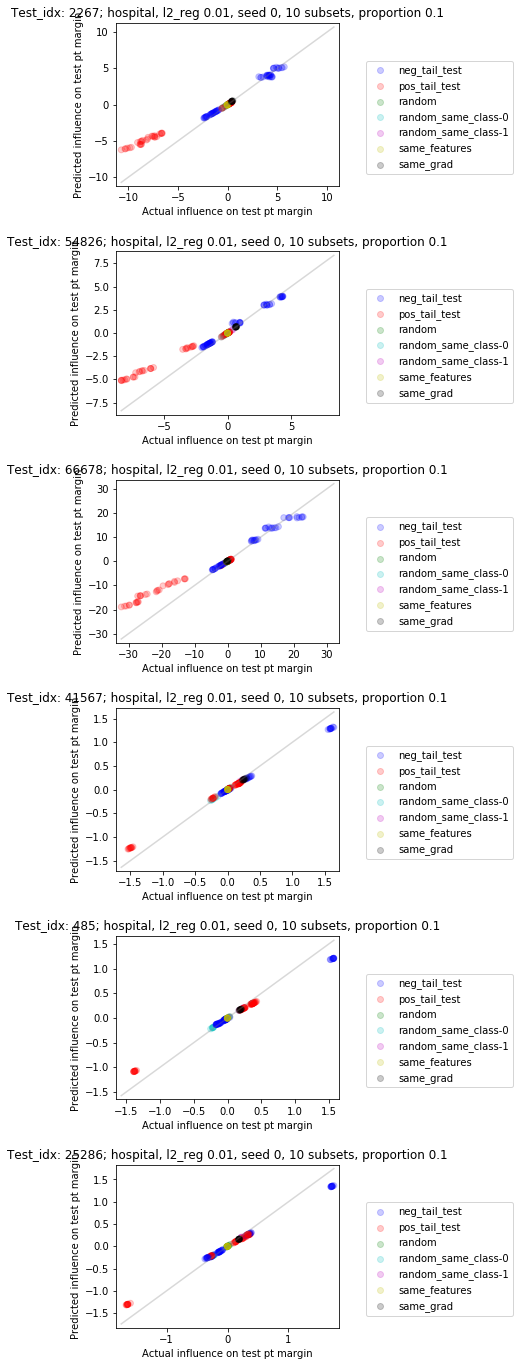

In [25]:
plot_all(1)

Experiment hospital_seed-0_size-0.1_num-10_reg-0.1
Loading phase 0-report_reg from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-0.1/result_0-report_reg.npz
Loading phase 1-initial_training from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-0.1/result_1-initial_training.npz
Loading phase 2-pick_test_points from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-0.1/result_2-pick_test_points.npz
Loading phase 3-hessian from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-0.1/result_3-hessian.npz
Loading phase 4-fixed_test_influence from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-0.1/result_4-fixed_test_influence.npz
Loading pha

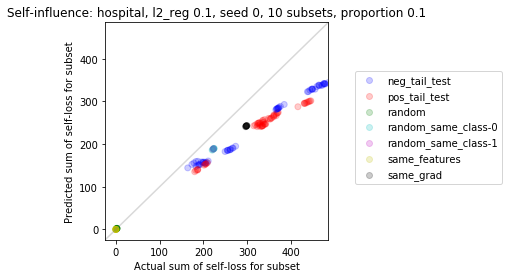

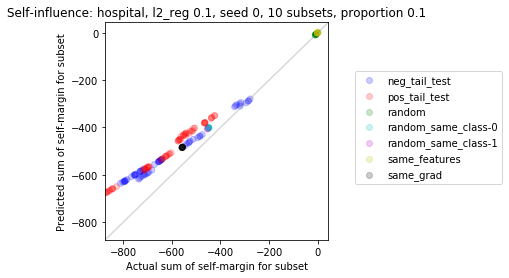

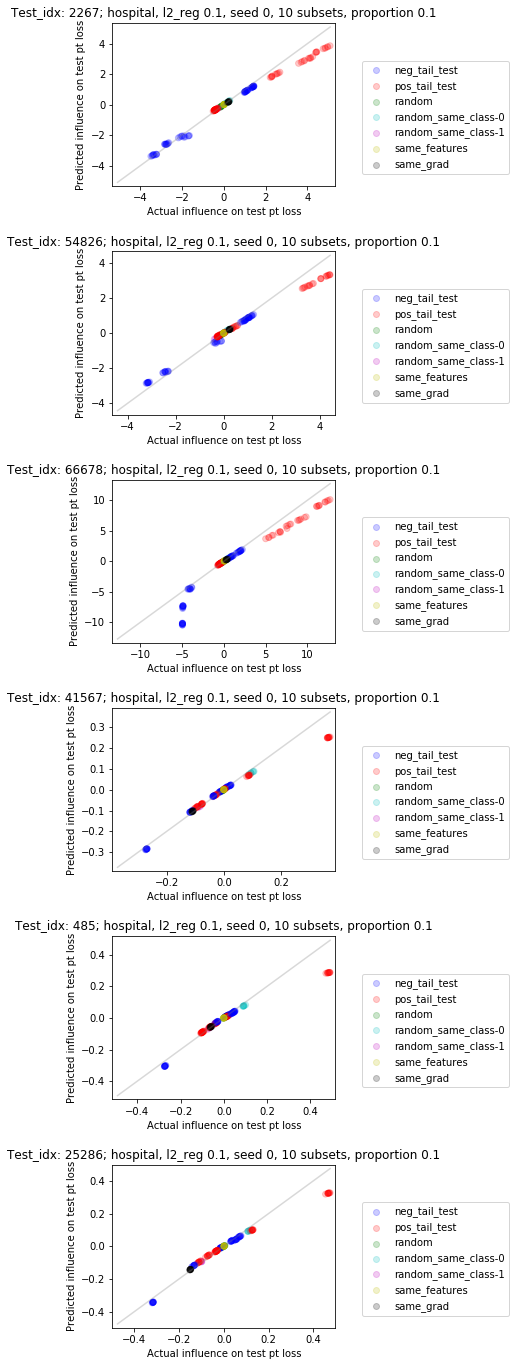

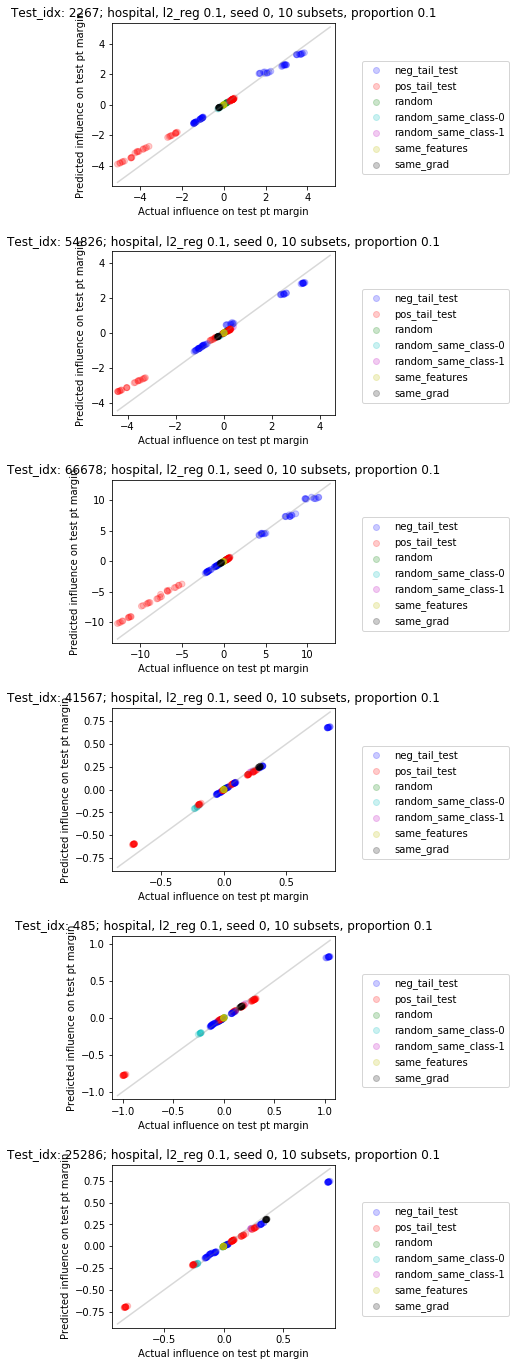

In [26]:
plot_all(2)

Experiment hospital_seed-0_size-0.1_num-10_reg-1.0
Loading phase 0-report_reg from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-1.0/result_0-report_reg.npz
Loading phase 1-initial_training from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-1.0/result_1-initial_training.npz
Loading phase 2-pick_test_points from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-1.0/result_2-pick_test_points.npz
Loading phase 3-hessian from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-1.0/result_3-hessian.npz
Loading phase 4-fixed_test_influence from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-1.0/result_4-fixed_test_influence.npz
Loading pha

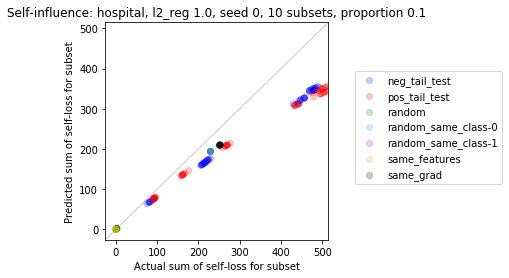

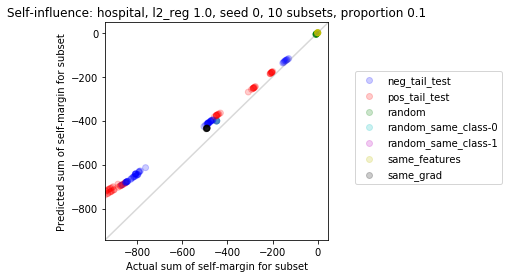

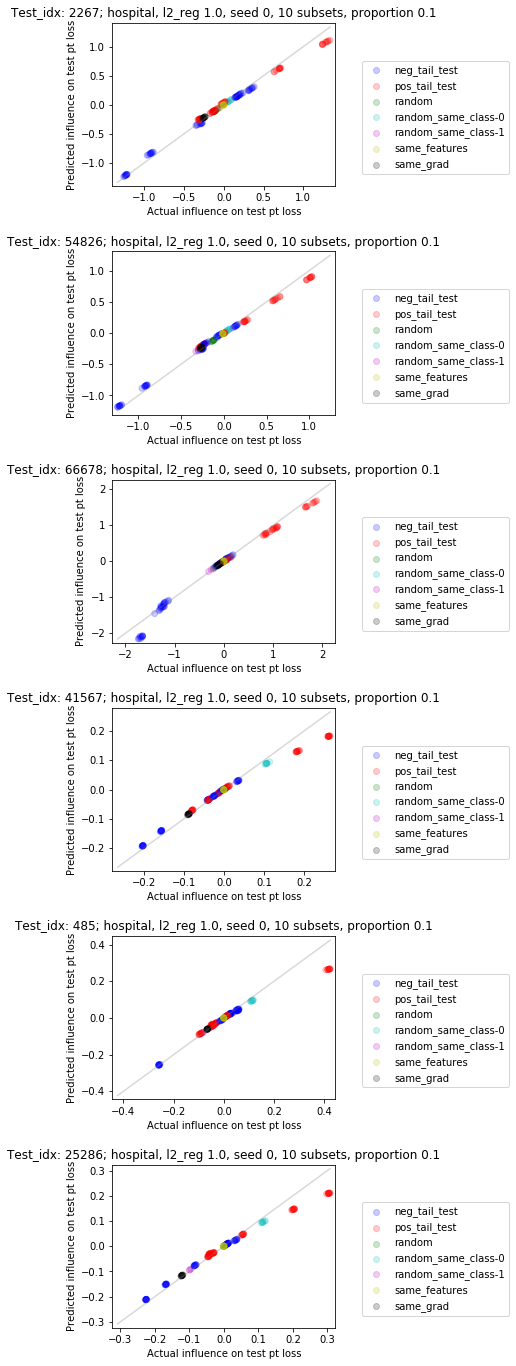

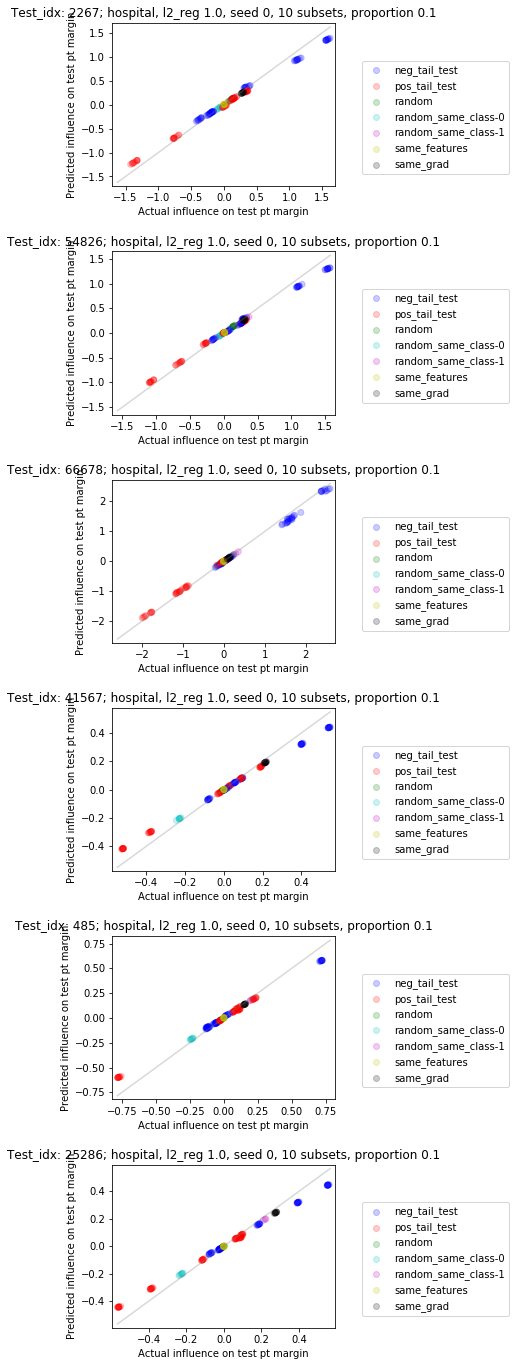

In [27]:
plot_all(3)

Experiment hospital_seed-0_size-0.1_num-10_reg-10.0
Loading phase 0-report_reg from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-10.0/result_0-report_reg.npz
Loading phase 1-initial_training from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-10.0/result_1-initial_training.npz
Loading phase 2-pick_test_points from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-10.0/result_2-pick_test_points.npz
Loading phase 3-hessian from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-10.0/result_3-hessian.npz
Loading phase 4-fixed_test_influence from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-10.0/result_4-fixed_test_influence.npz
Loadi

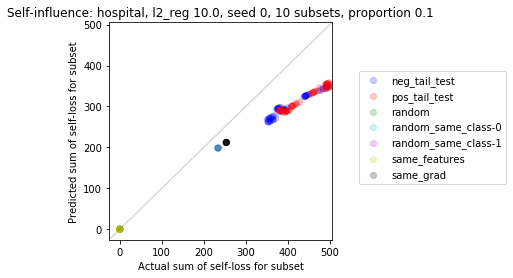

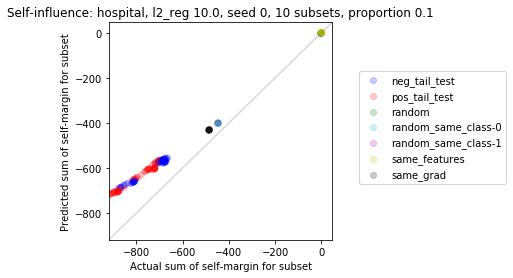

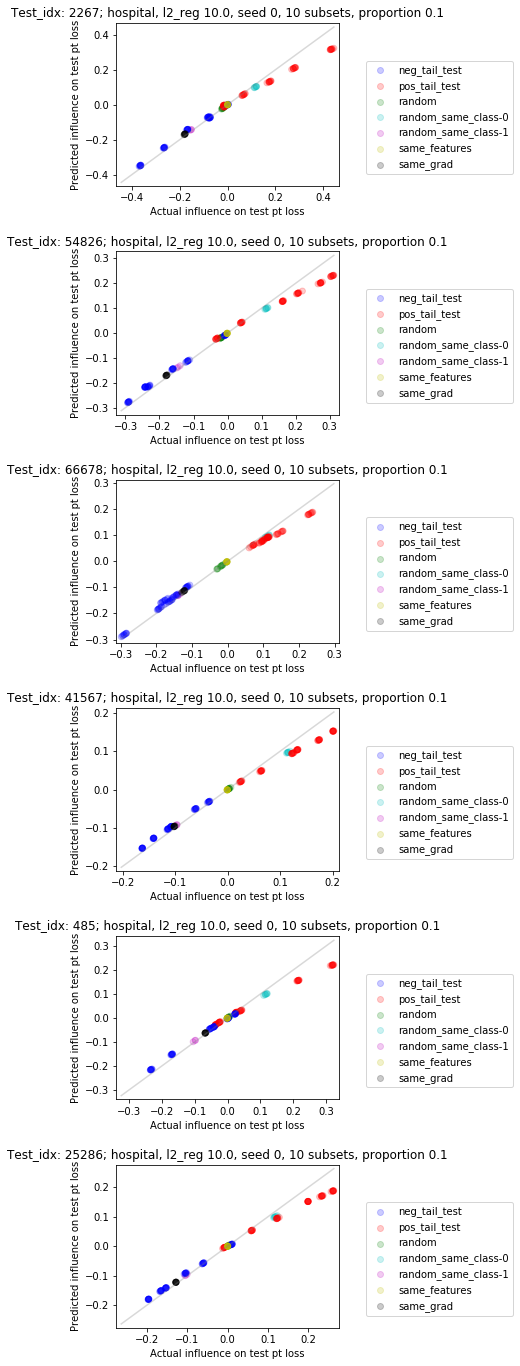

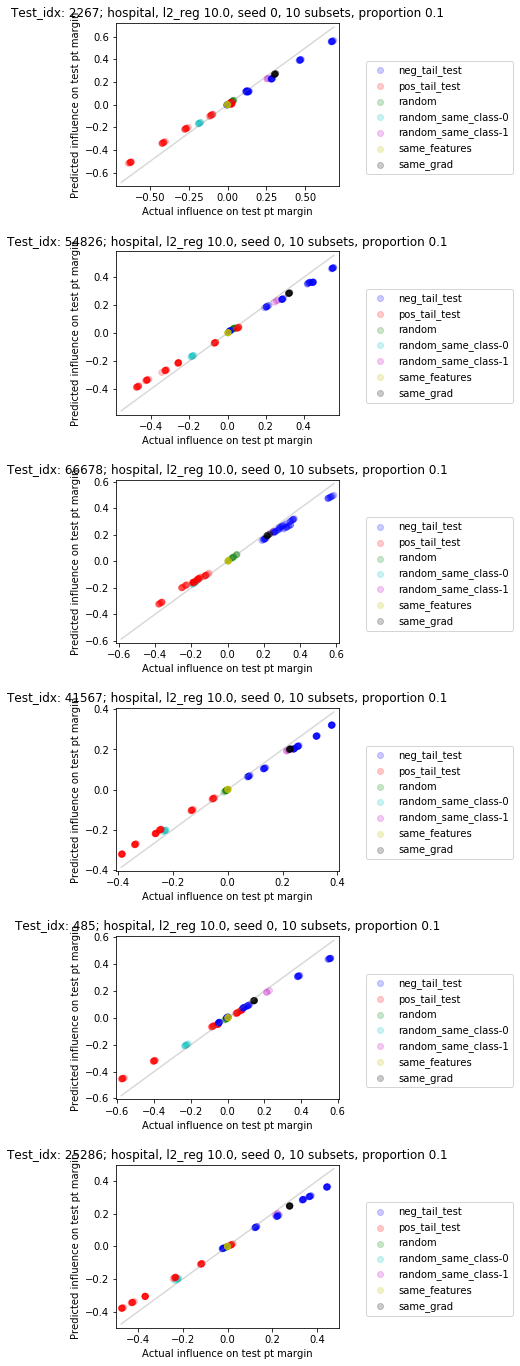

In [28]:
plot_all(4)

Experiment hospital_seed-0_size-0.1_num-10_reg-100.0
Loading phase 0-report_reg from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-100.0/result_0-report_reg.npz
Loading phase 1-initial_training from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-100.0/result_1-initial_training.npz
Loading phase 2-pick_test_points from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-100.0/result_2-pick_test_points.npz
Loading phase 3-hessian from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-100.0/result_3-hessian.npz
Loading phase 4-fixed_test_influence from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-100.0/result_4-fixed_test_influence.npz

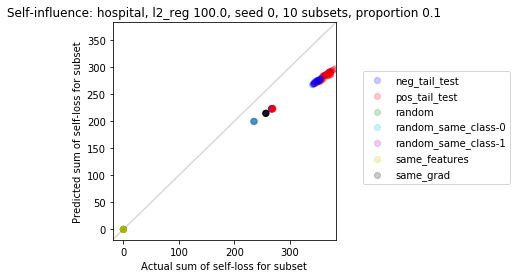

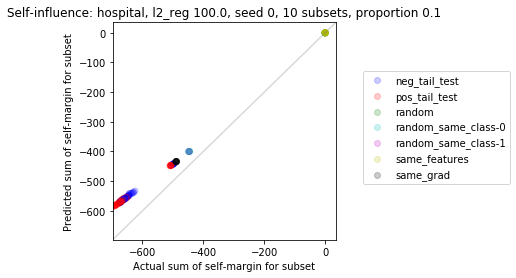

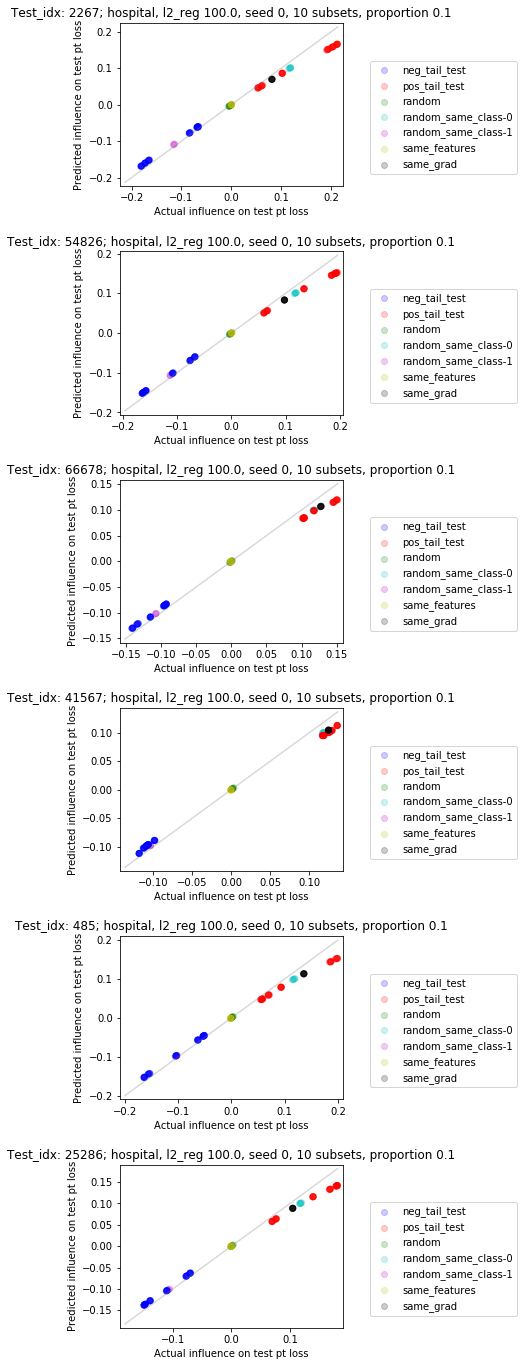

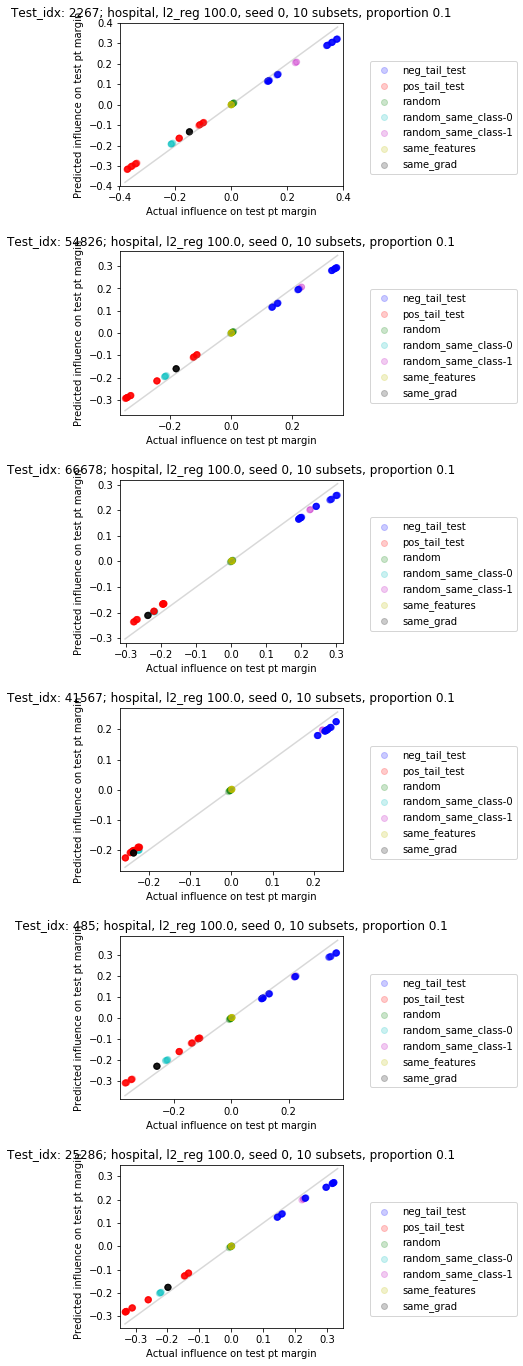

In [29]:
plot_all(5)

Experiment hospital_seed-0_size-0.1_num-10_reg-1000.0
Loading phase 0-report_reg from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-1000.0/result_0-report_reg.npz
Loading phase 1-initial_training from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-1000.0/result_1-initial_training.npz
Loading phase 2-pick_test_points from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-1000.0/result_2-pick_test_points.npz
Loading phase 3-hessian from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-1000.0/result_3-hessian.npz
Loading phase 4-fixed_test_influence from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-1000.0/result_4-fixed_test_influen

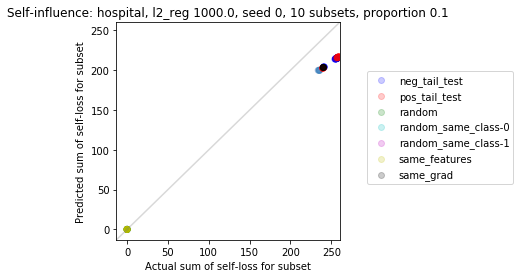

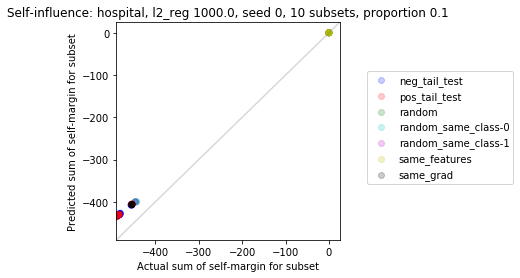

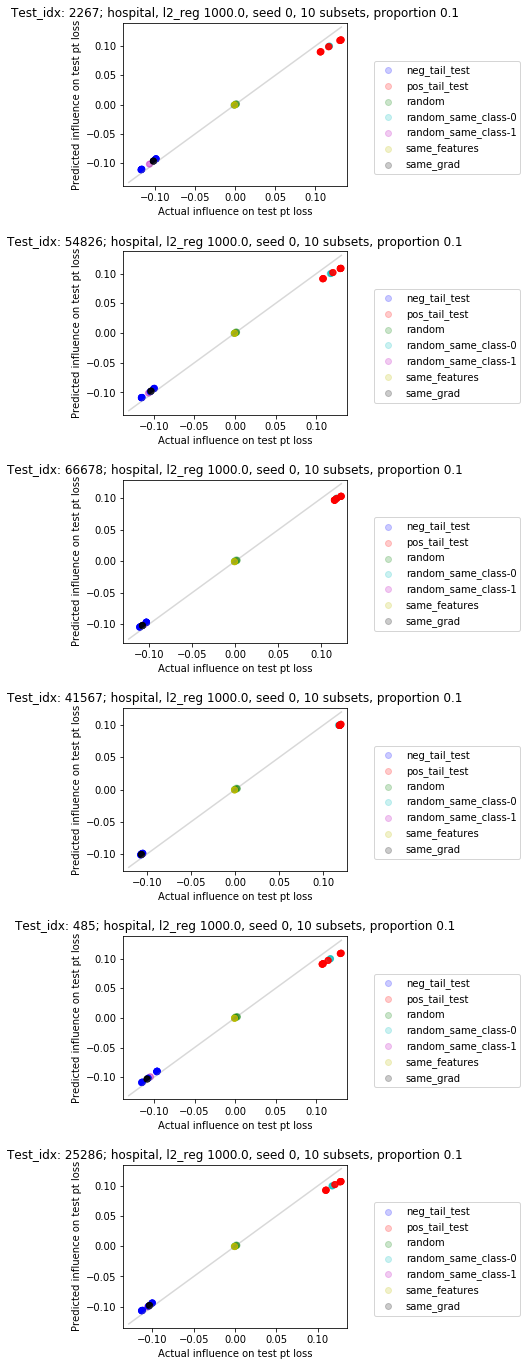

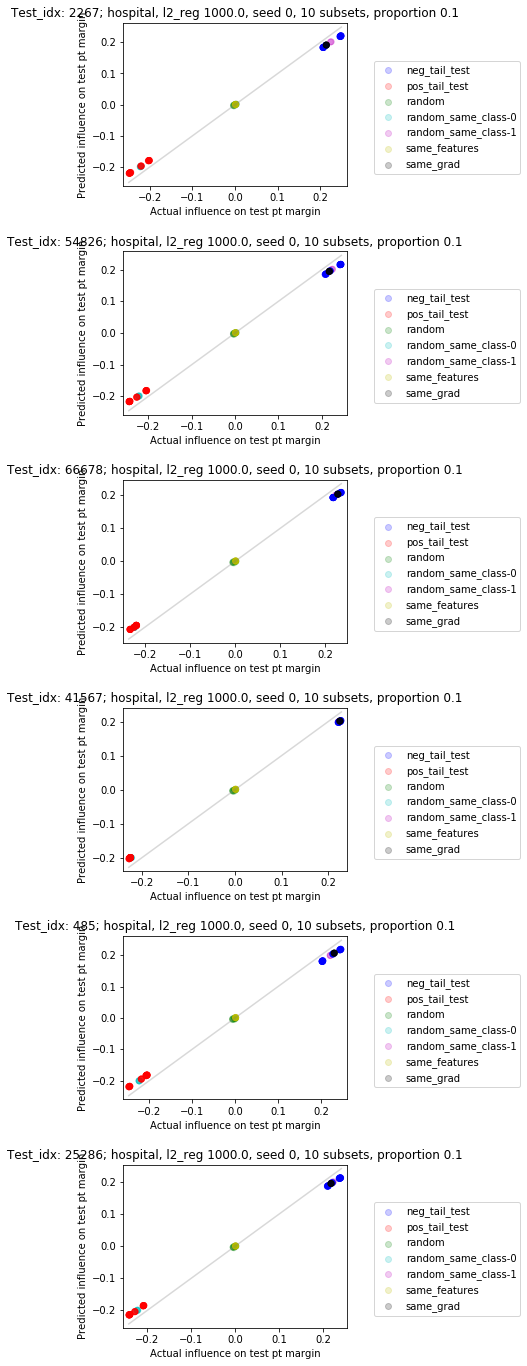

In [30]:
plot_all(6)

In [31]:
plot_all(7)

Experiment hospital_seed-0_size-0.1_num-10_reg-10000.0
Loading phase 0-report_reg from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-10000.0/result_0-report_reg.npz
Loading phase 1-initial_training from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-10000.0/result_1-initial_training.npz
Loading phase 2-pick_test_points from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-10000.0/result_2-pick_test_points.npz
Loading phase 3-hessian from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-10000.0/result_3-hessian.npz
Loading phase 4-fixed_test_influence from previous run:
/juice/scr/scr106/scr/kaiang/influence-release/output/suff_reg_logreg/hospital_seed-0_size-0.1_num-10_reg-10000.0/result_4-fixed_test_i

AssertionError: 

In [ ]:
plot_all(8)

In [ ]:
plot_all(9)

In [ ]:
plot_all(10)

In [ ]:
plot_all(11)

In [ ]:
plot_all(12)

In [ ]:
plot_all(13)

In [ ]:
plot_all(14)

In [ ]:
plot_all(15)

In [ ]:
plot_all(16)

In [ ]:
plot_all(17)

In [ ]:
plot_reg_summary()